In [17]:
# importing relevant libraries
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction import FeatureHasher
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from keras.layers import Dense, Dropout, BatchNormalization
from keras import optimizers, regularizers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, f1_score
import warnings
warnings.filterwarnings("ignore")

In [18]:
# dataset reading
ROOT_DIR = "/Users/nikunjlad"   # defining the root dir
data = pd.read_csv(os.path.join(ROOT_DIR, "data") + "/loan.csv")   # reading the csv file using pandas
data.head()   # observing the head of the dataframe

,Sex,Age,Time_at_address,Res_status,Telephone,Occupation,Job_status,Time_employed,Time_bank,Liab_ref,Acc_ref,Home_Expn,Balance,Decision
0,M,50.750000,0.585,owner,given,unemploye,unemploye,0,0,f,given,145,0,reject
1,M,19.670000,10.000,rent,not_given,labourer,governmen,0,0,t,given,140,0,reject
2,F,52.830002,15.000,owner,given,creative_,private_s,5,14,f,given,0,2200,accept
3,M,22.670000,2.540,rent,not_given,creative_,governmen,2,0,f,given,0,0,accept
4,M,29.250000,13.000,owner,given,driver,governmen,0,0,f,given,228,0,reject


In [19]:
# finding unique values
def get_unique_values(cols):
    
    # create a dictionary to hold unique values in the columns and the number of unique values
    unique_dict = dict()   
    for col in cols:
        obs = list()
        obs.append(list(data[col].unique()))  # list of unique values
        obs.append(len(obs[0]))  # num of unique values in the column
        unique_dict[col] = obs
        
    return unique_dict

In [20]:
cat_cols = ["Sex", "Res_status", "Telephone", "Liab_ref", "Acc_ref", "Occupation", "Job_status", "Decision"]   
unique_cols = get_unique_values(cat_cols)
unique_cols

{'Sex': [['M', 'F'], 2],
 'Res_status': [['owner', 'rent'], 2],
 'Telephone': [['given', 'not_given'], 2],
 'Liab_ref': [['f', 't'], 2],
 'Acc_ref': [['given', 'oth_inst_'], 2],
 'Occupation': [['unemploye',
   'labourer',
   'creative_',
   'driver',
   'professio',
   'manager',
   'guard_etc',
   'executive',
   'office_st',
   'productio',
   'semi_pro',
   'sales'],
  12],
 'Job_status': [['unemploye',
   'governmen',
   'private_s',
   'self_empl',
   'retired',
   'student',
   'military'],
  7],
 'Decision': [['reject', 'accept'], 2]}

In [21]:
query_cols = ["Sex", "Res_status", "Telephone", "Liab_ref", "Acc_ref", "Decision"]   
unique_cols_dict = get_unique_values(query_cols)
unique_cols_dict

{'Sex': [['M', 'F'], 2],
 'Res_status': [['owner', 'rent'], 2],
 'Telephone': [['given', 'not_given'], 2],
 'Liab_ref': [['f', 't'], 2],
 'Acc_ref': [['given', 'oth_inst_'], 2],
 'Decision': [['reject', 'accept'], 2]}

In [22]:
def label_features(feature_list):
    # function to encode the categorical columns
    feature_labels = list()   # labels list
    feature_mappings = list()  # corresponding mappings between the labels and categorical values
    for feature in feature_list:
        gle = LabelEncoder()
        feature_labels.append(gle.fit_transform(data[feature]))
        feature_mappings.append({index: label for index, label in enumerate(gle.classes_)})
    return feature_labels, feature_mappings

In [23]:
labels, mappings = label_features(query_cols)
mappings

[{0: 'F', 1: 'M'},
 {0: 'owner', 1: 'rent'},
 {0: 'given', 1: 'not_given'},
 {0: 'f', 1: 't'},
 {0: 'given', 1: 'oth_inst_'},
 {0: 'accept', 1: 'reject'}]

In [24]:
# replace the data column values with respective encoded labels
for ind, col in enumerate(query_cols):
    data[col] = labels[ind]

In [25]:
def feature_hasher(feature, num):
    
    # num is number of feature maps to generate with the hasher
    fh = FeatureHasher(n_features=num, input_type='string')
    hashed_features = fh.fit_transform(data[feature])
    hashed_features = hashed_features.toarray()
    col_names = [feature + str(n) for n in range(num)]
    df = pd.concat([data, pd.DataFrame(hashed_features, columns=col_names)], axis=1)
    return df

data = feature_hasher("Occupation", 6)
data = feature_hasher("Job_status", 4)
data = data.drop(["Occupation", "Job_status"], axis=1)
data.head()

,Sex,Age,Time_at_address,Res_status,Telephone,Time_employed,Time_bank,Liab_ref,Acc_ref,Home_Expn,...,Occupation0,Occupation1,Occupation2,Occupation3,Occupation4,Occupation5,Job_status0,Job_status1,Job_status2,Job_status3
0,1,50.750000,0.585,0,0,0,0,0,0,145,...,-2.0,3.0,1.0,0.0,3.0,0.0,2.0,0.0,0.0,3.0
1,1,19.670000,10.000,1,1,0,0,1,0,140,...,0.0,4.0,2.0,0.0,1.0,-1.0,-1.0,1.0,-1.0,2.0
2,0,52.830002,15.000,0,0,5,14,0,0,0,...,0.0,3.0,1.0,-1.0,0.0,-2.0,0.0,0.0,0.0,-1.0
3,1,22.670000,2.540,1,1,2,0,0,0,0,...,0.0,3.0,1.0,-1.0,0.0,-2.0,-1.0,1.0,-1.0,2.0
4,1,29.250000,13.000,0,0,0,0,0,0,228,...,0.0,4.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,2.0


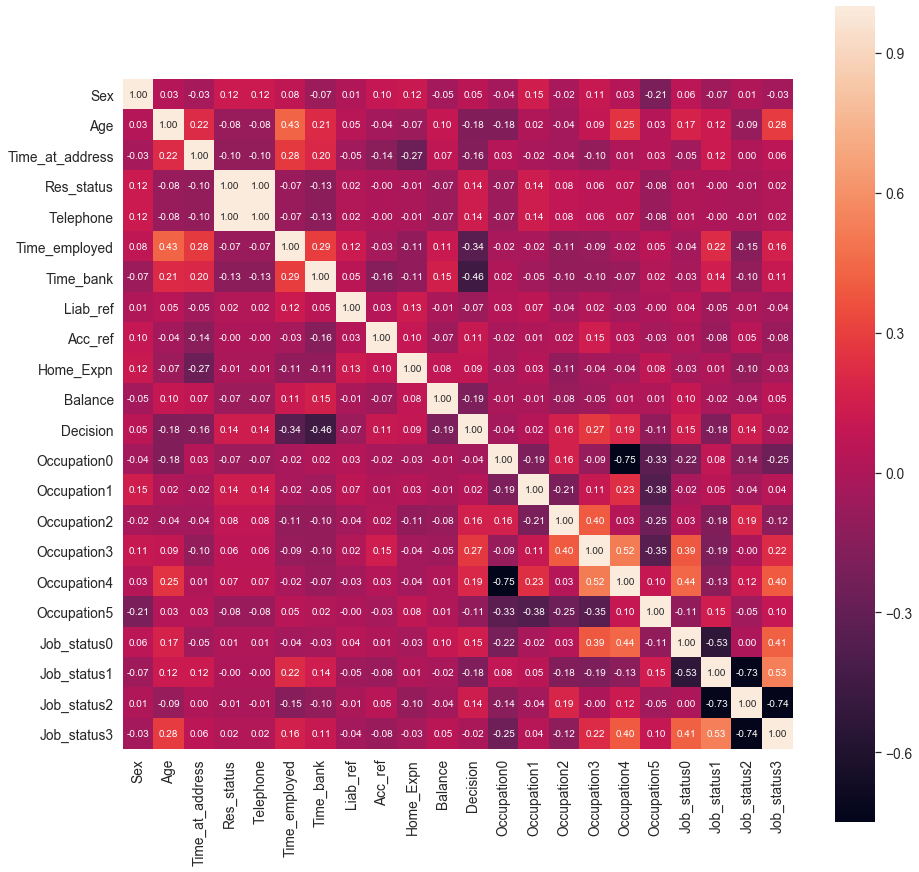

In [26]:
corr = data.corr()
cols = corr.index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(15, 15))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [27]:
df = data[["Age","Time_at_address","Time_employed","Time_bank","Balance","Occupation1","Occupation4","Occupation3",
            "Occupation5"]]
df.head()

,Age,Time_at_address,Time_employed,Time_bank,Balance,Occupation1,Occupation4,Occupation3,Occupation5
0,50.750000,0.585,0,0,0,3.0,3.0,0.0,0.0
1,19.670000,10.000,0,0,0,4.0,1.0,0.0,-1.0
2,52.830002,15.000,5,14,2200,3.0,0.0,-1.0,-2.0
3,22.670000,2.540,2,0,0,3.0,0.0,-1.0,-2.0
4,29.250000,13.000,0,0,0,4.0,0.0,-1.0,-1.0


In [28]:
df["Decision"] = data["Decision"]
df.head()

,Age,Time_at_address,Time_employed,Time_bank,Balance,Occupation1,Occupation4,Occupation3,Occupation5,Decision
0,50.750000,0.585,0,0,0,3.0,3.0,0.0,0.0,1
1,19.670000,10.000,0,0,0,4.0,1.0,0.0,-1.0,1
2,52.830002,15.000,5,14,2200,3.0,0.0,-1.0,-2.0,0
3,22.670000,2.540,2,0,0,3.0,0.0,-1.0,-2.0,0
4,29.250000,13.000,0,0,0,4.0,0.0,-1.0,-1.0,1


In [29]:
data = df.to_numpy()
np.random.shuffle(data)
X = data[:,:-1]
y = data[:,-1:]

In [30]:
# we have 3% testing data and 10% validation data for our modelling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.03, random_state = 333)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.07, random_state = 333)

In [31]:
# define network architecture
model = Sequential()
model.add(Dense(12, input_dim=9, activation="relu", kernel_initializer='random_uniform'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(24, activation='relu', kernel_initializer='random_uniform'))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))

# define optimizer, loss function for learning and metrics for evaluation
sgd = optimizers.SGD(lr=0.10, decay=1e-6, momentum=0.7, nesterov=True)
# adam = optimizers.Adam(learning_rate=0.1)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy','mse'])

# fit your model
history = model.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_valid, y_valid))

# # get the accuracy of the model
scores = model.evaluate(X_valid, y_valid)
print('Accuracy: %.2f' %(scores[1] * 100))

Train on 386 samples, validate on 30 samples
Epoch 1/300
386/386 [==============================] - 1s 1ms/step - loss: 0.6316 - accuracy: 0.6451 - mse: 0.2217 - val_loss: 0.6461 - val_accuracy: 0.7000 - val_mse: 0.2269
Epoch 2/300
386/386 [==============================] - 0s 103us/step - loss: 0.6479 - accuracy: 0.6606 - mse: 0.2255 - val_loss: 0.6734 - val_accuracy: 0.6333 - val_mse: 0.2402
Epoch 3/300
386/386 [==============================] - 0s 101us/step - loss: 0.6538 - accuracy: 0.6295 - mse: 0.2306 - val_loss: 0.6659 - val_accuracy: 0.6000 - val_mse: 0.2365
Epoch 4/300
386/386 [==============================] - 0s 104us/step - loss: 0.6579 - accuracy: 0.6580 - mse: 0.2316 - val_loss: 0.6450 - val_accuracy: 0.7000 - val_mse: 0.2261
Epoch 5/300
386/386 [==============================] - 0s 111us/step - loss: 0.6485 - accuracy: 0.6606 - mse: 0.2269 - val_loss: 0.6574 - val_accuracy: 0.7333 - val_mse: 0.2322
Epoch 6/300
386/386 [==============================] - 0s 125us/step - l

Epoch 47/300
386/386 [==============================] - 0s 84us/step - loss: 0.6498 - accuracy: 0.6528 - mse: 0.2281 - val_loss: 0.6476 - val_accuracy: 0.7000 - val_mse: 0.2274
Epoch 48/300
386/386 [==============================] - 0s 84us/step - loss: 0.6339 - accuracy: 0.6684 - mse: 0.2211 - val_loss: 0.6288 - val_accuracy: 0.7000 - val_mse: 0.2183
Epoch 49/300
386/386 [==============================] - 0s 82us/step - loss: 0.6412 - accuracy: 0.6451 - mse: 0.2248 - val_loss: 0.6336 - val_accuracy: 0.7000 - val_mse: 0.2209
Epoch 50/300
386/386 [==============================] - 0s 82us/step - loss: 0.6287 - accuracy: 0.6762 - mse: 0.2180 - val_loss: 0.6426 - val_accuracy: 0.7000 - val_mse: 0.2254
Epoch 51/300
386/386 [==============================] - 0s 82us/step - loss: 0.6513 - accuracy: 0.6580 - mse: 0.2287 - val_loss: 0.6586 - val_accuracy: 0.7000 - val_mse: 0.2328
Epoch 52/300
386/386 [==============================] - 0s 80us/step - loss: 0.6566 - accuracy: 0.6554 - mse: 0.231

386/386 [==============================] - 0s 82us/step - loss: 0.6287 - accuracy: 0.6969 - mse: 0.2168 - val_loss: 0.6378 - val_accuracy: 0.7000 - val_mse: 0.2232
Epoch 94/300
386/386 [==============================] - 0s 86us/step - loss: 0.6409 - accuracy: 0.6658 - mse: 0.2238 - val_loss: 0.6341 - val_accuracy: 0.7000 - val_mse: 0.2208
Epoch 95/300
386/386 [==============================] - 0s 82us/step - loss: 0.6295 - accuracy: 0.6736 - mse: 0.2190 - val_loss: 0.7113 - val_accuracy: 0.4333 - val_mse: 0.2595
Epoch 96/300
386/386 [==============================] - 0s 83us/step - loss: 0.6419 - accuracy: 0.6710 - mse: 0.2248 - val_loss: 0.6663 - val_accuracy: 0.7000 - val_mse: 0.2369
Epoch 97/300
386/386 [==============================] - 0s 95us/step - loss: 0.6234 - accuracy: 0.6865 - mse: 0.2168 - val_loss: 0.6476 - val_accuracy: 0.7000 - val_mse: 0.2274
Epoch 98/300
386/386 [==============================] - 0s 87us/step - loss: 0.6333 - accuracy: 0.6710 - mse: 0.2208 - val_loss:

386/386 [==============================] - 0s 89us/step - loss: 0.6707 - accuracy: 0.6062 - mse: 0.2388 - val_loss: 0.6842 - val_accuracy: 0.5667 - val_mse: 0.2456
Epoch 140/300
386/386 [==============================] - 0s 91us/step - loss: 0.6677 - accuracy: 0.6218 - mse: 0.2373 - val_loss: 0.6945 - val_accuracy: 0.5667 - val_mse: 0.2504
Epoch 141/300
386/386 [==============================] - 0s 92us/step - loss: 0.6592 - accuracy: 0.6321 - mse: 0.2331 - val_loss: 0.7078 - val_accuracy: 0.4333 - val_mse: 0.2573
Epoch 142/300
386/386 [==============================] - 0s 89us/step - loss: 0.6623 - accuracy: 0.6347 - mse: 0.2348 - val_loss: 0.6928 - val_accuracy: 0.5667 - val_mse: 0.2496
Epoch 143/300
386/386 [==============================] - 0s 99us/step - loss: 0.6622 - accuracy: 0.5855 - mse: 0.2350 - val_loss: 0.6903 - val_accuracy: 0.5667 - val_mse: 0.2484
Epoch 144/300
386/386 [==============================] - 0s 89us/step - loss: 0.6624 - accuracy: 0.6218 - mse: 0.2348 - val_

386/386 [==============================] - 0s 89us/step - loss: 0.6434 - accuracy: 0.6269 - mse: 0.2264 - val_loss: 0.6564 - val_accuracy: 0.6333 - val_mse: 0.2319
Epoch 186/300
386/386 [==============================] - 0s 88us/step - loss: 0.6576 - accuracy: 0.6244 - mse: 0.2324 - val_loss: 0.6589 - val_accuracy: 0.6333 - val_mse: 0.2330
Epoch 187/300
386/386 [==============================] - 0s 84us/step - loss: 0.6472 - accuracy: 0.6399 - mse: 0.2277 - val_loss: 0.6724 - val_accuracy: 0.4333 - val_mse: 0.2400
Epoch 188/300
386/386 [==============================] - 0s 84us/step - loss: 0.6503 - accuracy: 0.6321 - mse: 0.2275 - val_loss: 0.6519 - val_accuracy: 0.6667 - val_mse: 0.2296
Epoch 189/300
386/386 [==============================] - 0s 82us/step - loss: 0.6574 - accuracy: 0.6140 - mse: 0.2323 - val_loss: 0.6707 - val_accuracy: 0.4333 - val_mse: 0.2390
Epoch 190/300
386/386 [==============================] - 0s 85us/step - loss: 0.6460 - accuracy: 0.6218 - mse: 0.2275 - val_

386/386 [==============================] - 0s 95us/step - loss: 0.6654 - accuracy: 0.6347 - mse: 0.2358 - val_loss: 0.6539 - val_accuracy: 0.6333 - val_mse: 0.2305
Epoch 232/300
386/386 [==============================] - 0s 86us/step - loss: 0.6644 - accuracy: 0.6166 - mse: 0.2356 - val_loss: 0.6591 - val_accuracy: 0.6000 - val_mse: 0.2332
Epoch 233/300
386/386 [==============================] - 0s 83us/step - loss: 0.6628 - accuracy: 0.6192 - mse: 0.2348 - val_loss: 0.6565 - val_accuracy: 0.7000 - val_mse: 0.2318
Epoch 234/300
386/386 [==============================] - 0s 87us/step - loss: 0.6467 - accuracy: 0.6477 - mse: 0.2272 - val_loss: 0.6584 - val_accuracy: 0.7000 - val_mse: 0.2327
Epoch 235/300
386/386 [==============================] - 0s 85us/step - loss: 0.6526 - accuracy: 0.6425 - mse: 0.2288 - val_loss: 0.6539 - val_accuracy: 0.7000 - val_mse: 0.2305
Epoch 236/300
386/386 [==============================] - 0s 88us/step - loss: 0.6489 - accuracy: 0.6580 - mse: 0.2281 - val_

386/386 [==============================] - 0s 88us/step - loss: 0.6523 - accuracy: 0.6347 - mse: 0.2289 - val_loss: 0.6473 - val_accuracy: 0.6333 - val_mse: 0.2274
Epoch 278/300
386/386 [==============================] - 0s 88us/step - loss: 0.6573 - accuracy: 0.6244 - mse: 0.2323 - val_loss: 0.6533 - val_accuracy: 0.7000 - val_mse: 0.2303
Epoch 279/300
386/386 [==============================] - 0s 88us/step - loss: 0.6536 - accuracy: 0.6269 - mse: 0.2308 - val_loss: 0.6571 - val_accuracy: 0.7000 - val_mse: 0.2320
Epoch 280/300
386/386 [==============================] - 0s 87us/step - loss: 0.6496 - accuracy: 0.6580 - mse: 0.2284 - val_loss: 0.6776 - val_accuracy: 0.4333 - val_mse: 0.2424
Epoch 281/300
386/386 [==============================] - 0s 91us/step - loss: 0.6509 - accuracy: 0.6477 - mse: 0.2296 - val_loss: 0.6532 - val_accuracy: 0.7000 - val_mse: 0.2302
Epoch 282/300
386/386 [==============================] - 0s 89us/step - loss: 0.6509 - accuracy: 0.6373 - mse: 0.2286 - val_